# Visualizing Regression Uncertainty

In this notebook we visualize regression uncertainties for subspace inference.

In [2]:
import sys
import matplotlib.cm as cm
import scipy.stats as st
import math
from subspace_inference.posteriors.proj_model import SubspaceModel

In [3]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import HMC, MCMC, NUTS

from subspace_inference.posteriors.pyro import PyroModel
from subspace_inference.utils import extract_parameters, set_weights

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.utils.data
from torch.nn import functional as F

import seaborn as sns

import subspace_inference.utils as utils
from subspace_inference.posteriors import SWAG
from subspace_inference import models, losses, utils
from subspace_inference.models import MLP
from tqdm import tqdm

import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

%load_ext autoreload
%autoreload 2

In [5]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
bc = sklearn.datasets.load_breast_cancer()

In [7]:
X_numpy, y_numpy = bc.data, bc.target

In [8]:
y_numpy = y_numpy.reshape(-1, 1)

In [9]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_numpy.astype(np.float32)), 
                                         torch.from_numpy(y_numpy.astype(np.float32)))
loader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)


In [10]:
x, y = loader.dataset.tensors

In [11]:
model_cfg = models.ToyRegNet
# criterion = losses.GaussianLikelihood(noise_var=1.)
criterion = losses.binary_cross_entropy
model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)

In [12]:
def train(model, loader, optimizer, criterion, lr_init=1e-2, epochs=3000, 
          swag_model=None, swag=False, swag_start=2000, swag_freq=50, swag_lr=1e-3,
          print_freq=100):
    
    for epoch in range(epochs):
        t = (epoch + 1) / swag_start if swag else (epoch + 1) / epochs
        lr_ratio = swag_lr / lr_init if swag else 0.05
        
        if t <= 0.5:
            factor = 1.0
        elif t <= 0.9:
            factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
        else:
            factor = lr_ratio

        lr = factor * lr_init
        utils.adjust_learning_rate(optimizer, lr)
        
        train_res = utils.train_epoch(loader, model, criterion, optimizer, cuda=False, regression=True)
        if swag and epoch > swag_start:
            swag_model.collect_model(model)
        
        if (epoch % print_freq == 0 or epoch == epochs - 1):
            print('Epoch %d. LR: %g. Loss: %.4f' % (epoch, lr, train_res['loss']))

In [16]:
wd = 0.
lr_init = 1e-2
pretrained = True
model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
epochs = 5

if not pretrained:
    for i in range(epochs):
        print("Training Model with Breast Cancer", i)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr_init, weight_decay=wd)
        train(model, loader, optimizer, criterion, lr_init, 3000, print_freq=1000)
        torch.save(model.state_dict(), "ckpts/sgd_breast_cancer_checkpoint"+str(i+1)+".pt")
else:
    model.load_state_dict(torch.load("ckpts/sgd_breast_cancer_checkpoint" + str(epochs - 1) + ".pt"))

In [17]:
wd = 0.
lr_init = 1e-2

print("Training Swag Model")
swag_model = SWAG(model_cfg.base, subspace_type="pca", *model_cfg.args, **model_cfg.kwargs, 
              subspace_kwargs={"max_rank": 2, "pca_rank": 2})
model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
optimizer = torch.optim.SGD(model.parameters(), lr=lr_init, weight_decay=wd)

train(model, loader, optimizer, criterion, lr_init, 3000, print_freq=1000, 
      swag=True, swag_model=swag_model, swag_start=2000, swag_freq=100, swag_lr=1e-2)


Training Swag Model
Epoch 0. LR: 0.01. Loss: 2.5452
Epoch 1000. LR: 0.01. Loss: 2.2048
Epoch 2000. LR: 0.01. Loss: 2.2041
Epoch 2999. LR: 0.01. Loss: 2.2022


In [ ]:
check_model = model_cfg.base(*model_cfg.args, **model_cfg.kwargs)
set_weights(check_model, swag_model.mean)


In [123]:
def get_pca_space():
    mean, _, cov_factor = swag_model.get_space()
    subspace = SubspaceModel(mean, cov_factor)
    return subspace

In [124]:
swag_model.sample()

tensor([ 0.2078, -0.0566,  0.2975,  ..., -0.1364, -0.2231,  0.0829])

In [125]:
subspace = get_pca_space()
prior_sigma = 1.
# criterion = losses.GaussianLikelihood(noise_var=.05)
temperature = 0.5

pyro_model = PyroModel(
    base=model_cfg.base,
    subspace=subspace,
    prior_log_sigma=math.log(prior_sigma), 
    likelihood_given_outputs=lambda x: dist.Normal(x, np.sqrt(.05 / temperature)),
    *model_cfg.args,
    **model_cfg.kwargs
)

In [126]:
hmc_kernel = HMC(pyro_model.model, step_size=1.)

In [127]:
model

RegNetBase(
  (linear0): Linear(in_features=30, out_features=200, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=200, out_features=50, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=50, out_features=50, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=50, out_features=1, bias=True)
)

In [128]:
x_, y_ = loader.dataset.tensors

In [129]:
s = MCMC(hmc_kernel, num_samples=100, warmup_steps=200)
s.run(x_, y_)

Sample: 100%|█████████████████████████████████████████| 300/300 [02:23,  2.08it/s, step size=1.66e-01, acc. prob=0.844]


In [130]:
hmc_samples = s.get_samples()['t']

C:\Users\mehdi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehdi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


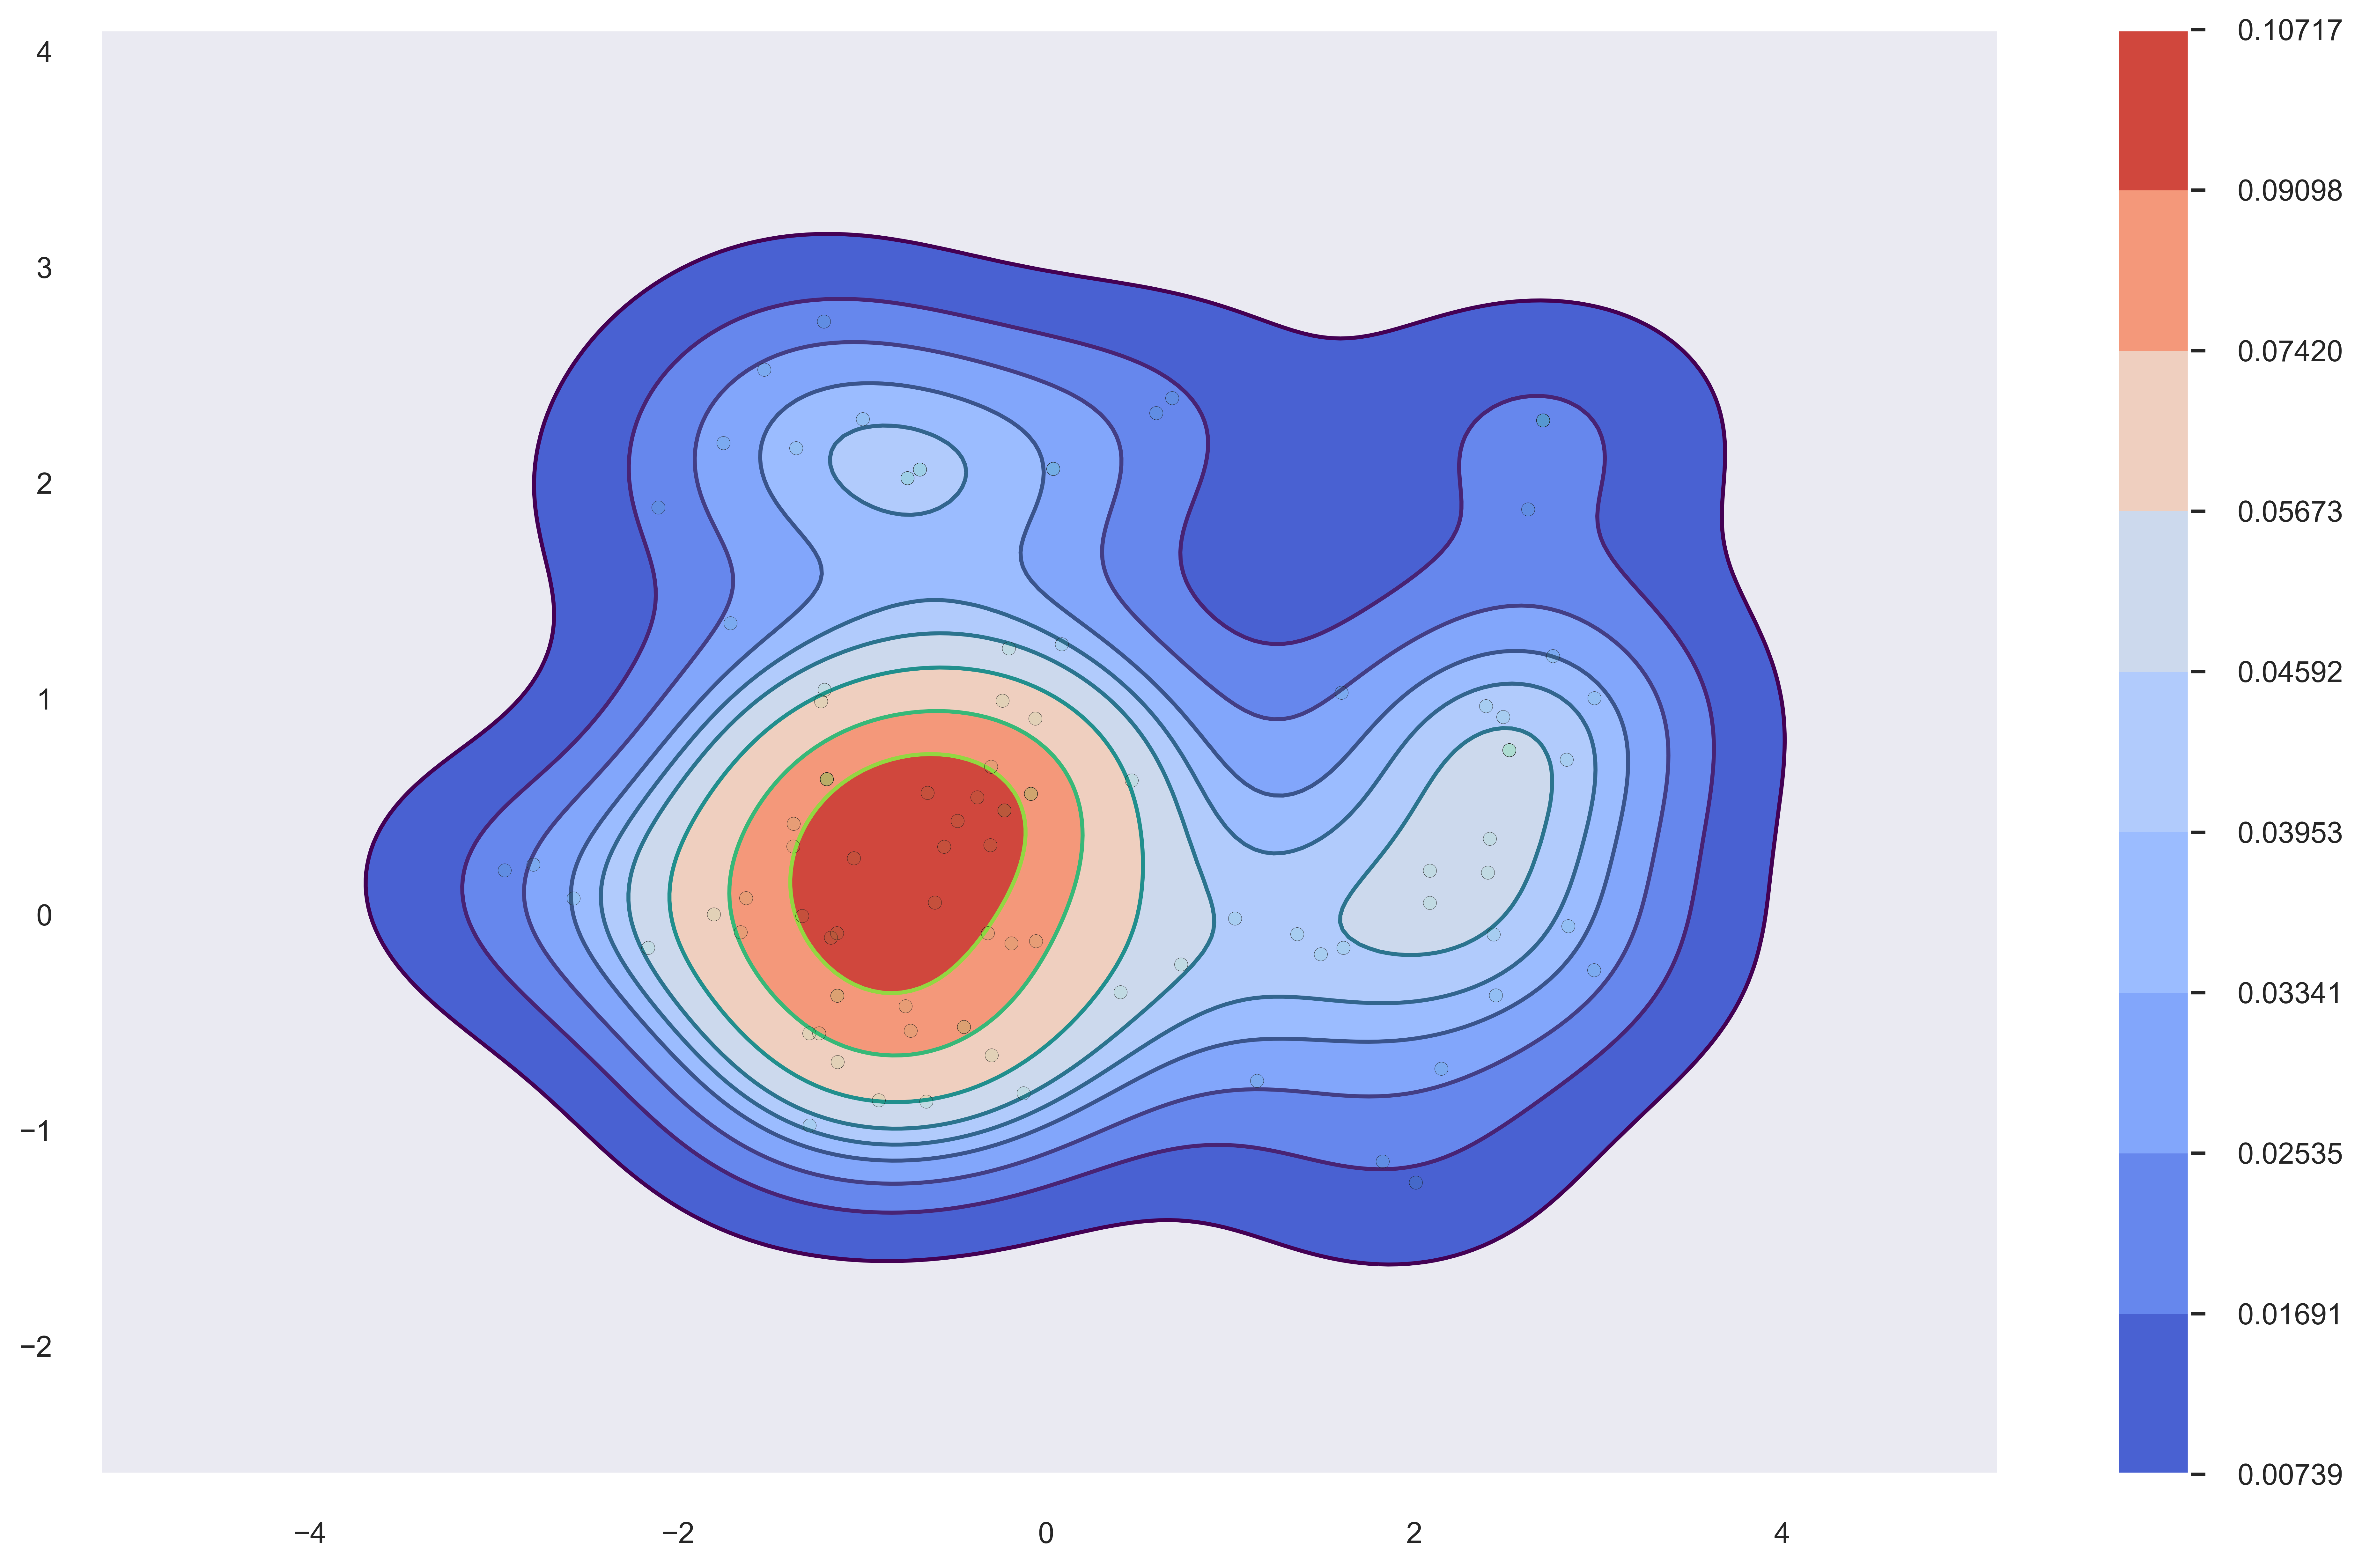

In [260]:
plt.figure(figsize=(16, 10))
plt.plot(hmc_samples[:, 0], hmc_samples[:, 1], color=(0, 1, 0.2, 0.05), linewidth=0, marker='o', markeredgewidth=0.1, markeredgecolor="k", markersize=5)
sns.set_style("dark", {'grid' : False})
# sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
with sns.axes_style("dark"):
    sns.kdeplot(
        hmc_samples[:, 0], hmc_samples[:, 1], fill=True, cbar=True, cmap='coolwarm'
    );
    sns.kdeplot(
        hmc_samples[:, 0], hmc_samples[:, 1], fill=False, cbar=False, cmap=cm.viridis
    );

plt.savefig("hmc_sample_2d.pdf", bbox_inches='tight')

In [133]:
Z = np.random.randn(100, 2)

C:\Users\mehdi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\mehdi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


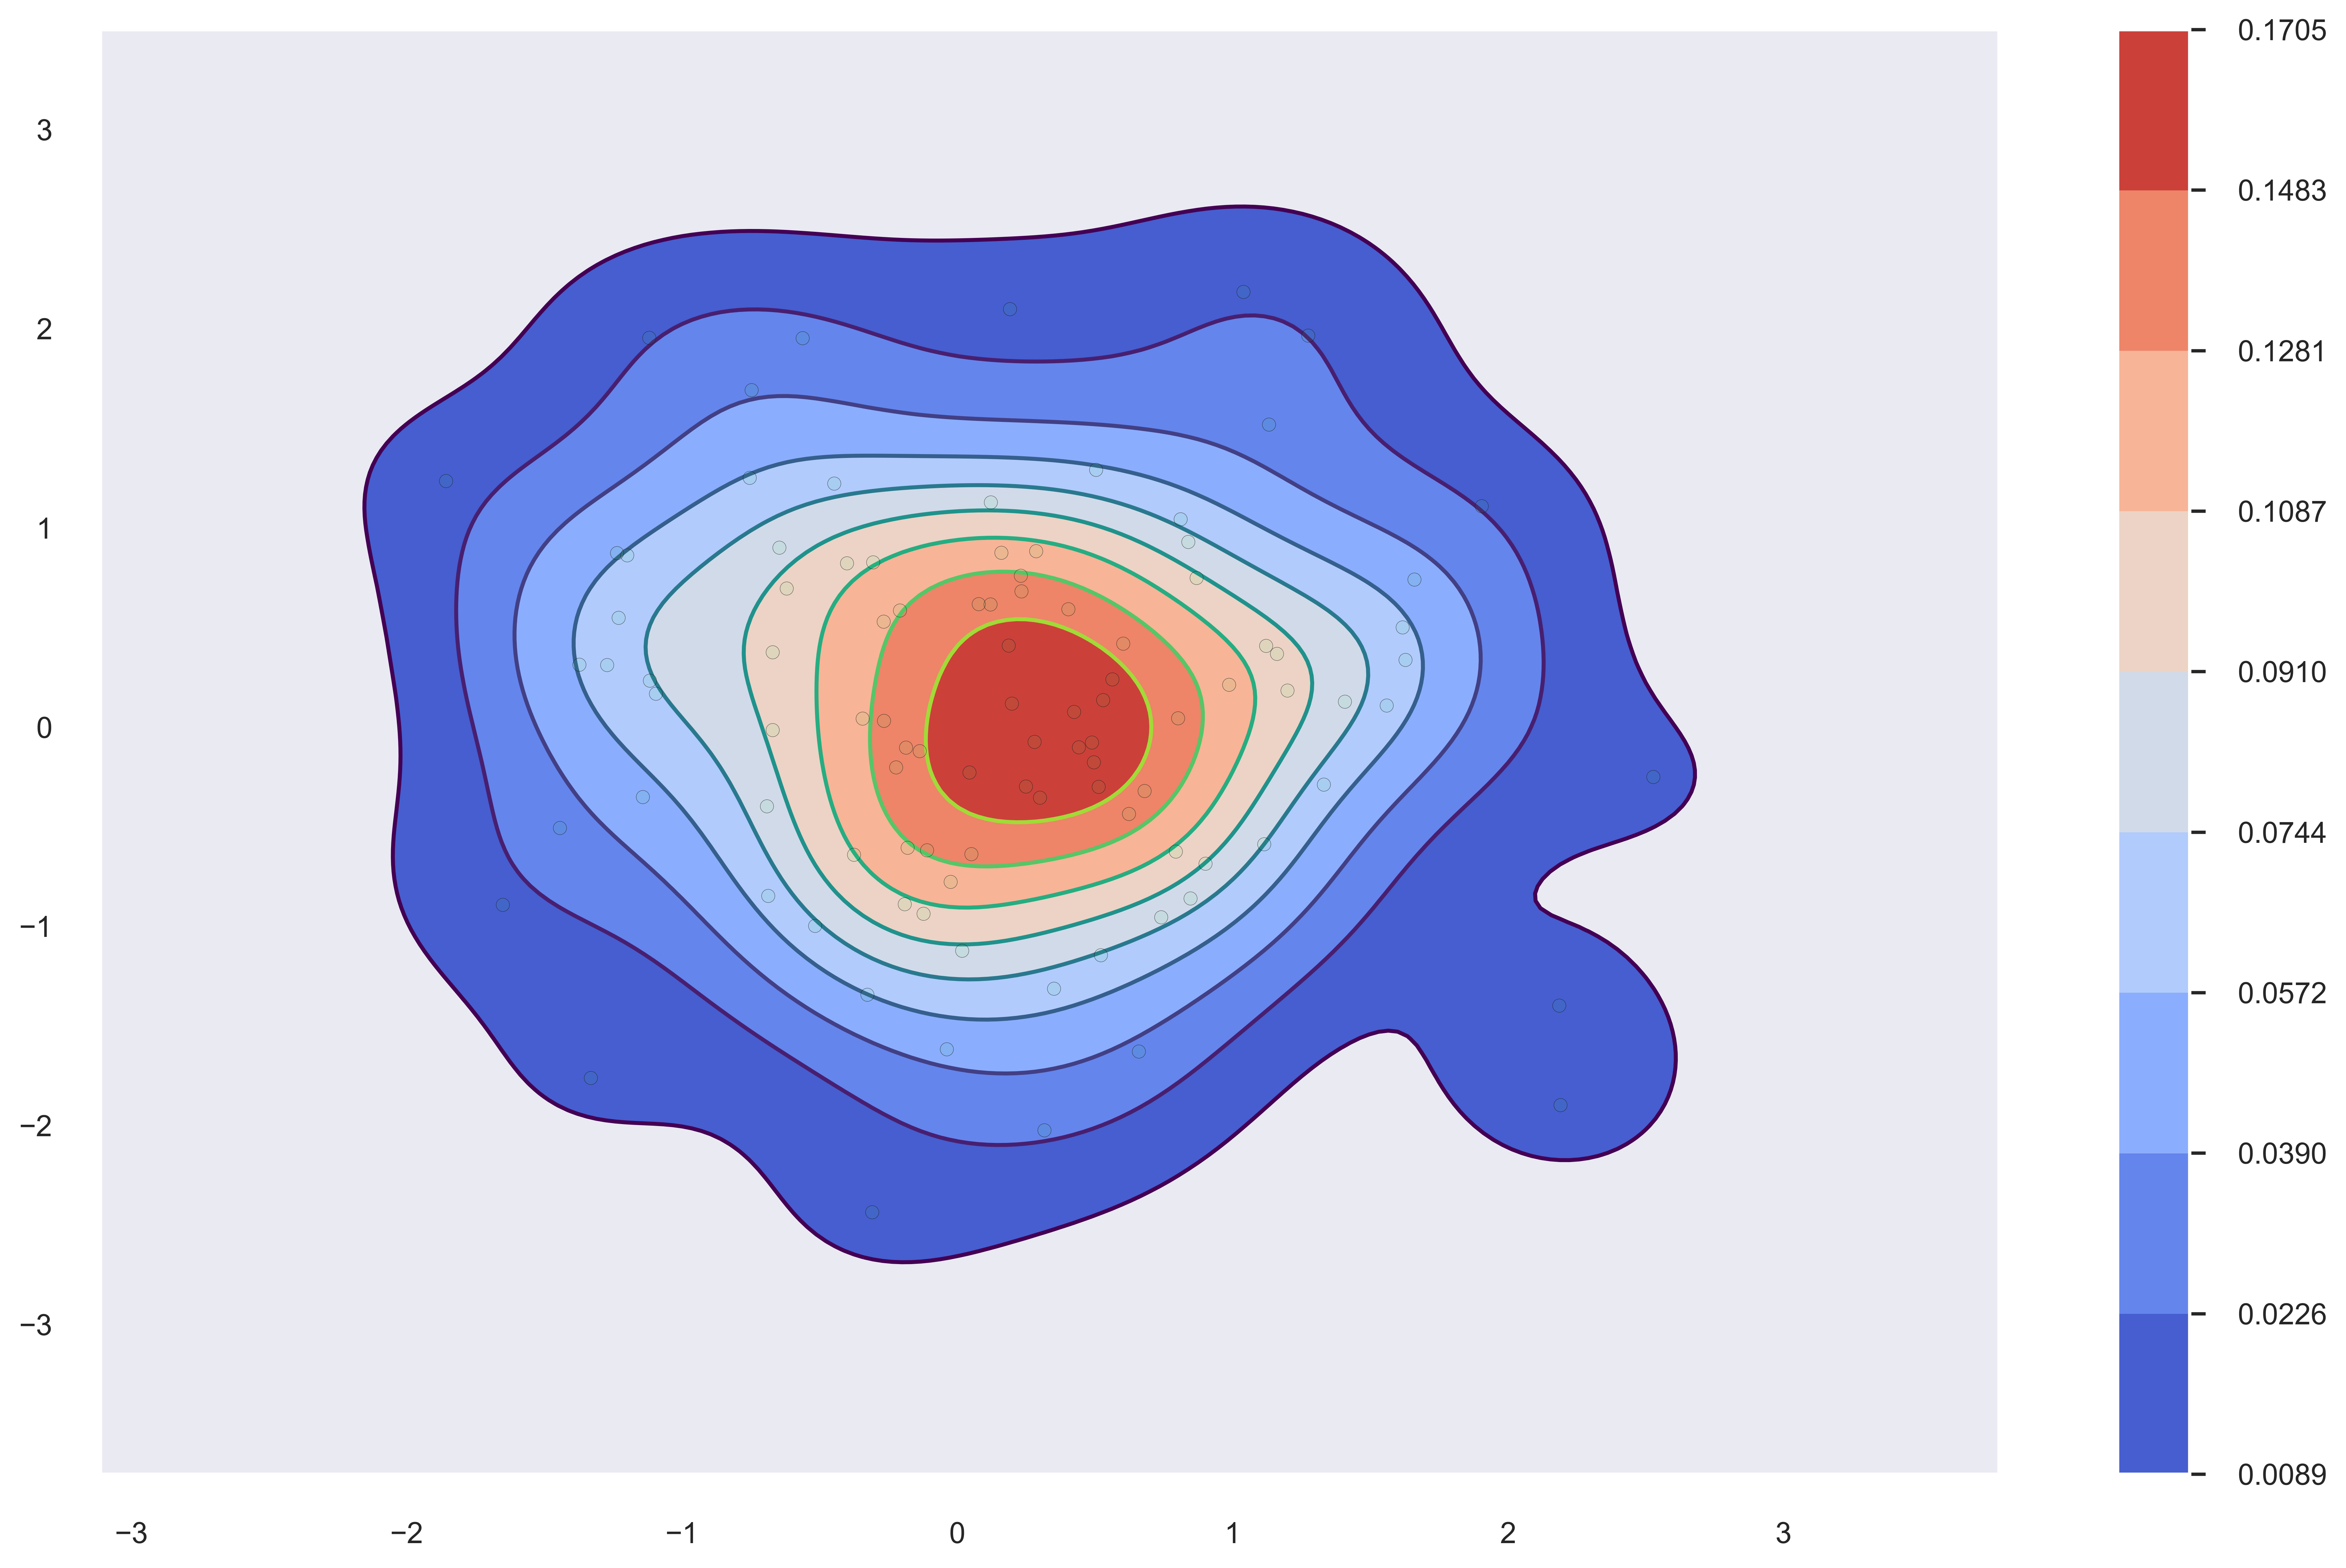

In [261]:
plt.figure(figsize=(16, 10))
plt.plot(Z[:, 0], Z[:, 1], color=(0, 1, 0.2, 0.05), linewidth=0, marker='o', markeredgewidth=0.1, markeredgecolor="k", markersize=5)
sns.set(rc={"figure.dpi":600, 'savefig.dpi':600})
sns.set_style("dark", {'grid' : False})

with sns.axes_style("dark"):
    sns.kdeplot(
        Z[:, 0], Z[:, 1], fill=True, cbar=True, cmap='coolwarm'
    );
    sns.kdeplot(
        Z[:, 0], Z[:, 1], fill=False, cbar=False, cmap=cm.viridis
    );

plt.savefig("swag_samples_2d.pdf", bbox_inches='tight')

In [188]:
samples_arr1 = np.array(hmc_samples)

In [207]:
samples_arr2 = np.array(Z)

In [181]:
# samples_arr = np.vstack([samples_arr1, samples_arr2])

In [214]:
x1 = samples_arr1[:, 0]
y1 = samples_arr1[:, 1]
x2 = samples_arr2[:, 0]
y2 = samples_arr2[:, 1]
# x = samples_arr[:, 0]
# y = samples_arr[:, 1]


# Define the borders
deltaX1 = (max(x1) - min(x1))/10
deltaY1 = (max(y1) - min(y1))/10
xmin1 = min(x1) - deltaX1
xmax1 = max(x1) + deltaX1
ymin1 = min(y1) - deltaY1
ymax1 = max(y1) + deltaY1
print(xmin1, xmax1, ymin1, ymax1)

deltaX2 = (max(x2) - min(x2))/10
deltaY2 = (max(y2) - min(y2))/10
xmin2 = min(x2) - deltaX2
xmax2 = max(x2) + deltaX2
ymin2 = min(y2) - deltaY2
ymax2 = max(y2) + deltaY2
print(xmin2, xmax2, ymin2, ymax2)


-3.533839988708496 3.5702839374542235 -1.639017367362976 3.1480309009552
-2.2966126215720672 2.966956463931713 -2.8970195052152783 2.649161388082397


In [215]:
# Create meshgrid
xx1, yy1 = np.mgrid[xmin1:xmax1:100j, ymin1:ymax1:100j]
positions1 = np.vstack([xx1.ravel(), yy1.ravel()])

xx2, yy2 = np.mgrid[xmin2:xmax2:100j, ymin2:ymax2:100j]
positions2 = np.vstack([xx2.ravel(), yy2.ravel()])


values1 = np.vstack([x1, y1])
kernel1 = st.gaussian_kde(values1)
f1 = np.reshape(kernel1(positions1).T, xx1.shape)

values2 = np.vstack([x2, y2])
kernel2 = st.gaussian_kde(values2)
f2 = np.reshape(kernel2(positions2).T, xx2.shape)

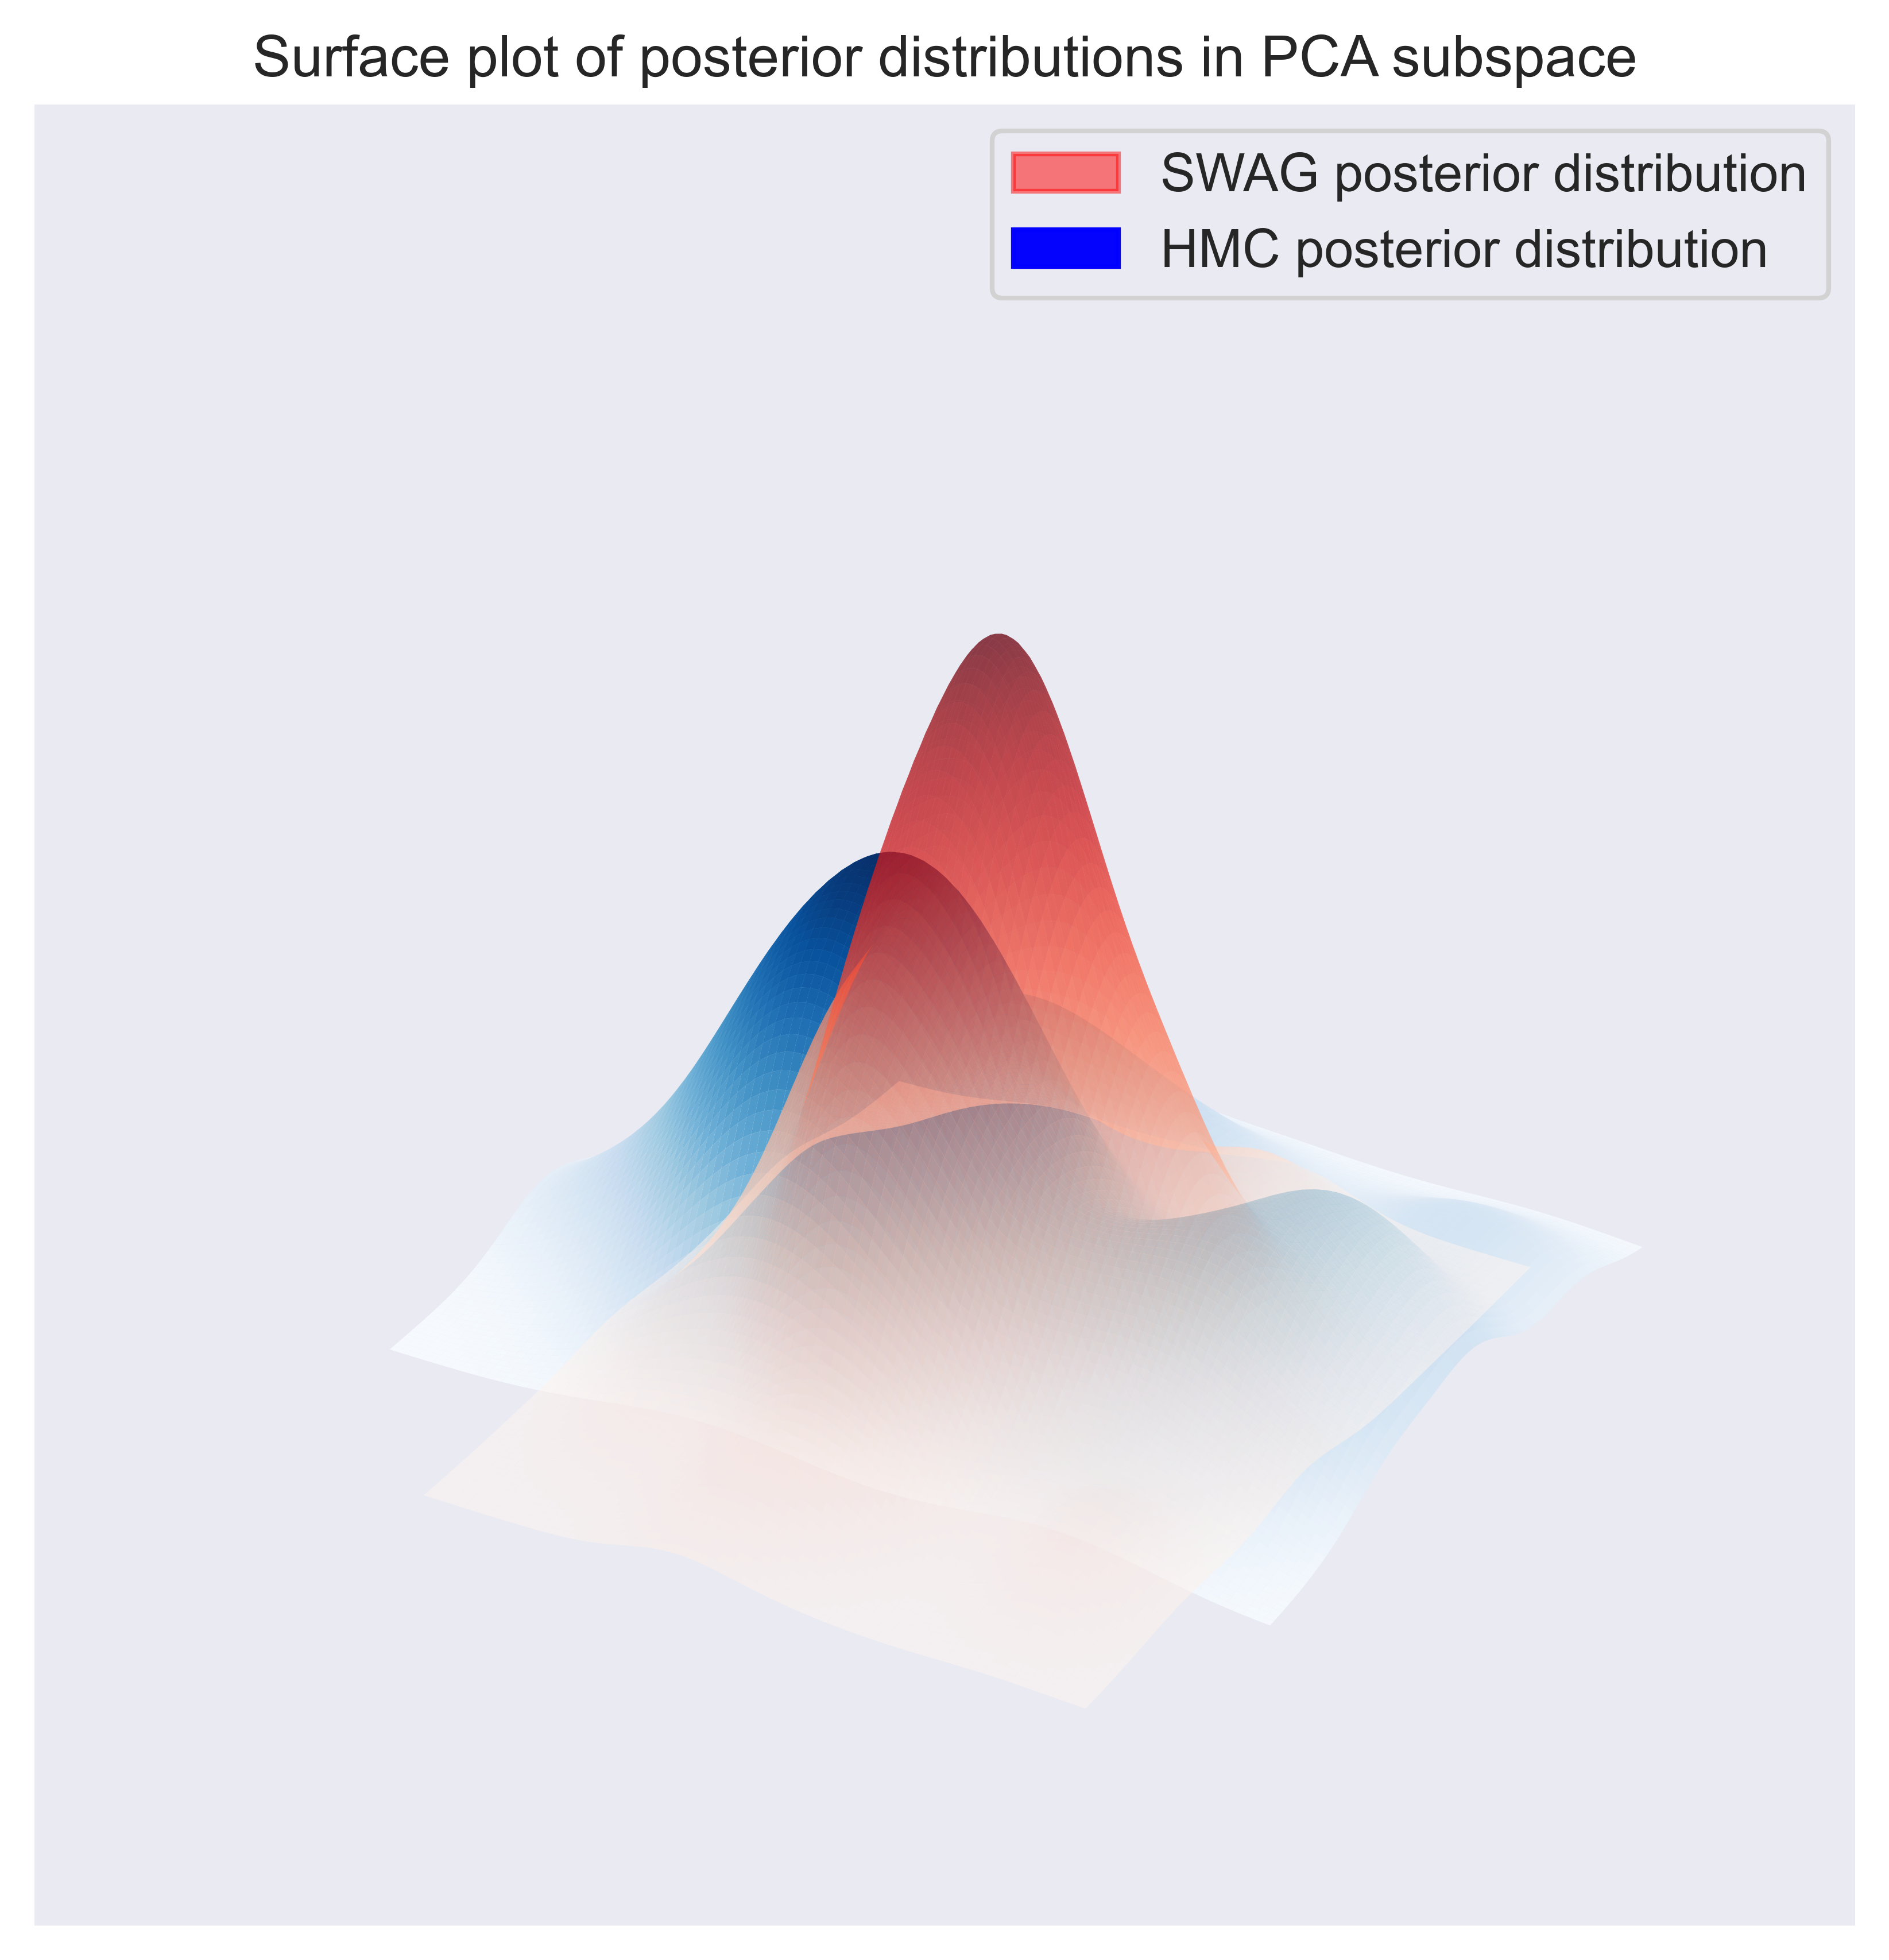

In [262]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')

surf2 = ax.plot_surface(xx2, yy2, f2, rstride=1, cstride=1, cmap='Reds', edgecolor='none', alpha=0.5, label='SWAG posterior distribution')
surf2._facecolors2d = surf2._facecolors3d
surf2._edgecolors2d = surf2._edgecolors3d

surf1 = ax.plot_surface(xx1, yy1, f1, rstride=1, cstride=1, cmap='Blues', edgecolor='none', alpha=0.99, label='HMC posterior distribution')
surf1._facecolors2d = surf1._facecolors3d
surf1._edgecolors2d = surf1._edgecolors3d

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.axis(False)
ax.set_title('Surface plot of posterior distributions in PCA subspace')

ax.legend()
leg = ax.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')

plt.savefig("posterior_distributions_subspace.pdf", bbox_inches='tight')